**Описание/Пошаговая инструкция выполнения домашнего задания:**

Вас пригласили на работу в коммерческую компанию, занимающуюся разработкой автоматизированных торговых агентов. Одной из первых ваших задач будет подготовка данных для дальнейшей обработки и построения модели. Пообщавшись с коллегами, вы узнали, что вам предстоит работать с несколькими типами активов: акциями из списка SnP500 и криптовалютами (BTC, ETH, SOL, XRP). Вам планируют поручить краткосрочную и среднесрочную торговлю.


**Вам предлагается на основе предоставленной информации:**

1. Создать git-репозиторий, где будет храниться исходный код вашего проекта. Если вы используете приватный репозиторий – дайте преподавателям курса доступ к нему, для возможности проверки ДЗ.
2. Добавить файл лицензии, который отражает ваш взгляд на конфиденциальность информации, которую вы подготовите в рамках данного курса.
3. Создать код на Python, который загрузит на ваш локальный компьютер данные о котировках ценных бумаг из списка SnP500 и котировки криптовалют (BTC, ETH, SOL, XRP).
4. Поскольку вам предстоит много работать с ними в дальнейшем, подготовьте автоматическое отображение графиков текущей ситуации.
5. Проверьте нет ли в данных пропусков или ошибок. Проанализируйте выбросы. Оцените, на самом ли деле это выбросы или реальные данные, с которыми предстоит работать.

In [1]:
!pip install ccxt -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 935.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 18.0 MB/s eta 0:00:00


In [2]:
!pip install mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.0 MB/s eta 0:00:00


In [12]:
import ccxt
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from IPython.display import display, Markdown


from scipy.stats import zscore

# Для тикеров криптовалюты испольуем coinbase,
# потому что yfinance предоставляет не все
# тикеры
exchange = ccxt.coinbase()

In [26]:
# Вычисляет диапазон дат длиною заданное
# количество дней
def subtract_days_from_date(date_str, days_to_subtract):
    date = datetime.strptime(date_str, "%Y-%m-%d")
    new_date = date - timedelta(days=days_to_subtract)
    return new_date.strftime("%Y-%m-%d")

In [27]:
# Загружает историю торгов для тикера из
# yfinance и приводит к единому формату
def load_sp_ticker(ticker, days):
  t = yf.Ticker(ticker)
  current_date = datetime.now().strftime("%Y-%m-%d")
  past_date = subtract_days_from_date(current_date, days)
  ohlcv = t.history(start=past_date, end=current_date, actions=False)
  ohlcv = ohlcv.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
  })

  # Если колонка 'Date' является индексом, её нужно сначала сбросить в колонку
  if ohlcv.index.name == 'Date':
    ohlcv = ohlcv.reset_index()
    ohlcv = ohlcv.rename(columns={'Date': 'date'})
  ohlcv['date'] = pd.to_datetime(ohlcv['date'], unit='ms')
  ohlcv.set_index('date', inplace=True)
  return ohlcv


In [28]:
# Загружает историю торгов для тикера из
# coinbase и приводит к единому формату
def load_ticker(ticker, days):
  timeframe = '1d'
  ohlcv = exchange.fetch_ohlcv(ticker, timeframe, limit=days)

  df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
  df.set_index('timestamp', inplace=True)
  return df


In [29]:
# Для заданной истории тикера рисует график,
# ищет пропуски и выбросы
def display_tickers(ticker_df, sigma):
  mpf.plot(ticker_df, type='candle', style='charles', title=f'Японские свечи {t} (1 час)', volume=True)
  display(Markdown(("**Ищем пропуски**")))
  print(ticker_df.isna().sum())
  ticker_df['Z-Score'] = zscore(ticker_df['close'])
  display(Markdown((f"**Ищем выбросы на цене закрытия (sigma = {sigma})**")))
  print(ticker_df[abs(ticker_df['Z-Score']) > sigma][['open', 'close', 'Z-Score']])

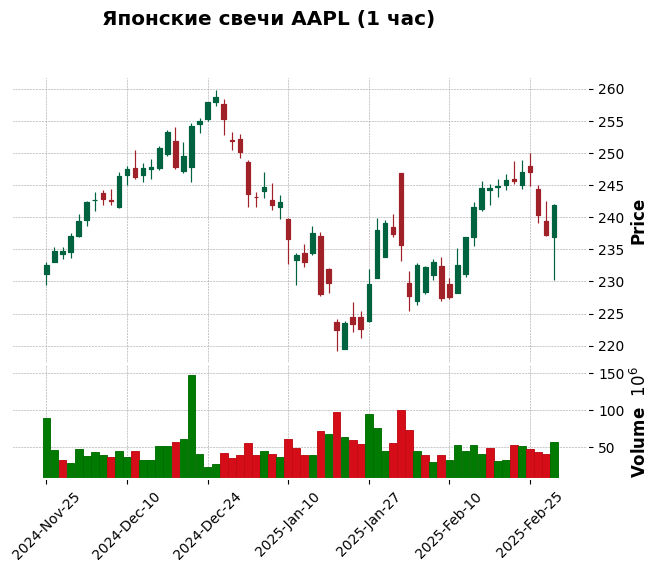

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 2)**

                                 open       close   Z-Score
date                                                       
2024-12-26 00:00:00-05:00  257.906429  258.735504  2.063204
2025-01-21 00:00:00-05:00  223.753984  222.395477 -2.028285
2025-01-24 00:00:00-05:00  224.533128  222.535324 -2.012540


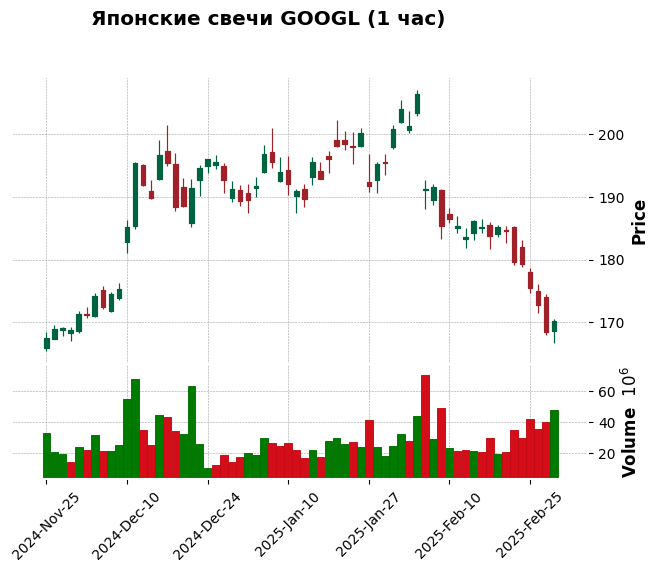

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 2)**

Empty DataFrame
Columns: [open, close, Z-Score]
Index: []


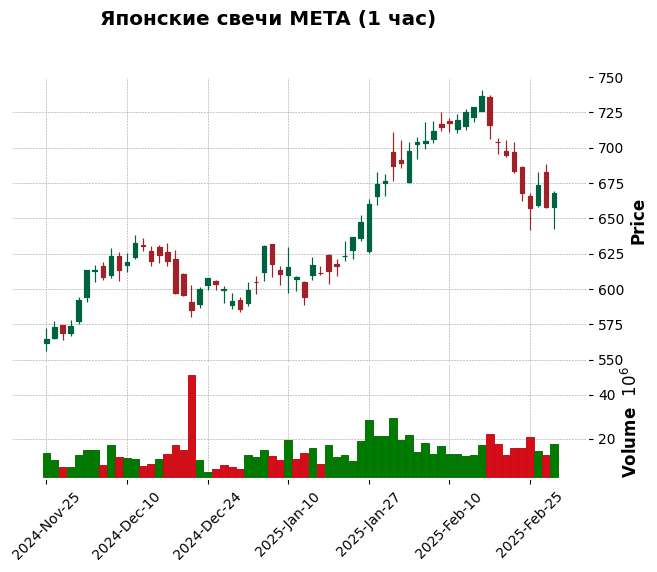

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 2)**

                                 open       close   Z-Score
date                                                       
2025-02-14 00:00:00-05:00  726.140015  736.669983  2.057803


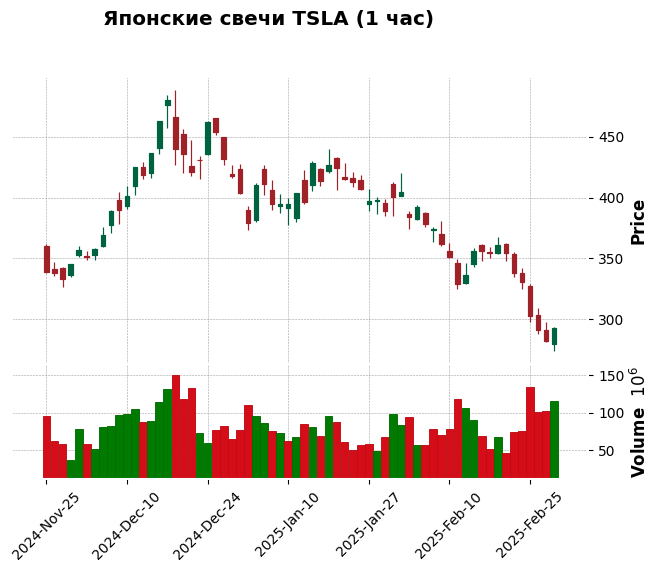

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 2)**

                                 open       close   Z-Score
date                                                       
2024-12-17 00:00:00-05:00  475.899994  479.859985  2.180504
2025-02-26 00:00:00-05:00  303.709991  290.799988 -2.218878
2025-02-27 00:00:00-05:00  291.160004  281.950012 -2.424815
2025-02-28 00:00:00-05:00  279.500000  292.980011 -2.168149


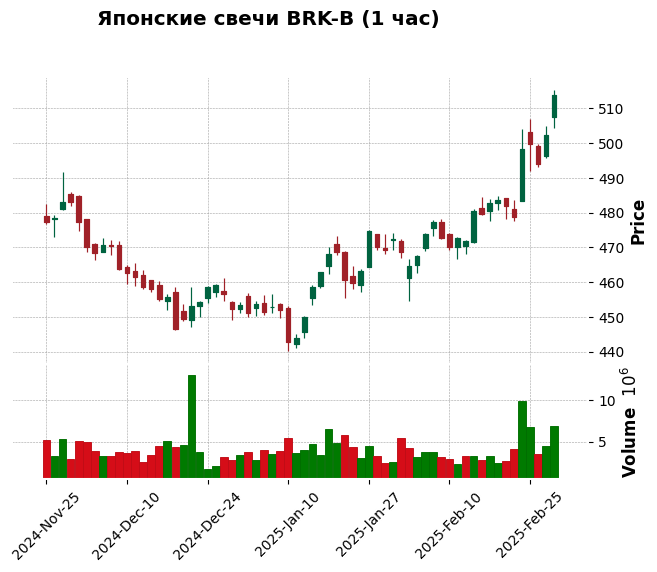

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 2)**

                                 open       close   Z-Score
date                                                       
2025-02-24 00:00:00-05:00  483.500000  498.420013  2.100675
2025-02-25 00:00:00-05:00  503.149994  499.820007  2.196620
2025-02-27 00:00:00-05:00  496.450012  502.410004  2.374120
2025-02-28 00:00:00-05:00  507.459991  513.830017  3.156767


In [30]:
tickers = ['AAPL', 'GOOGL', 'META', 'TSLA', 'BRK-B']

for t in tickers:
  ticker_df = load_sp_ticker(ticker=t, days=100)
  display_tickers(ticker_df=ticker_df, sigma=2)



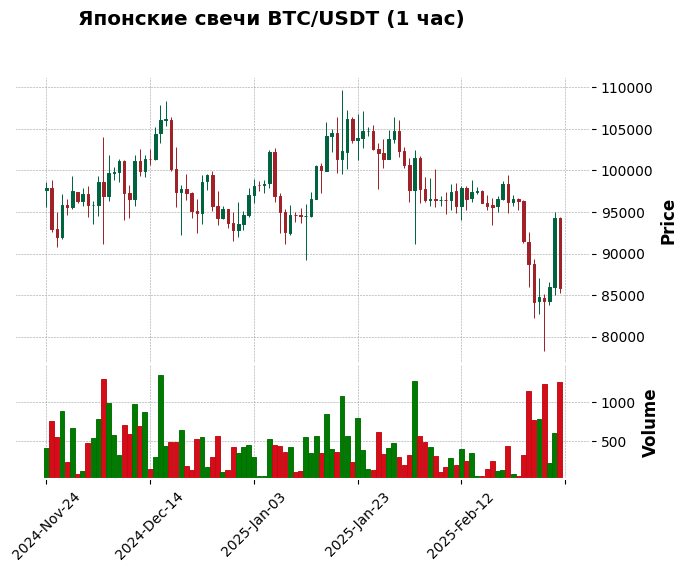

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 3)**

Empty DataFrame
Columns: [open, close, Z-Score]
Index: []


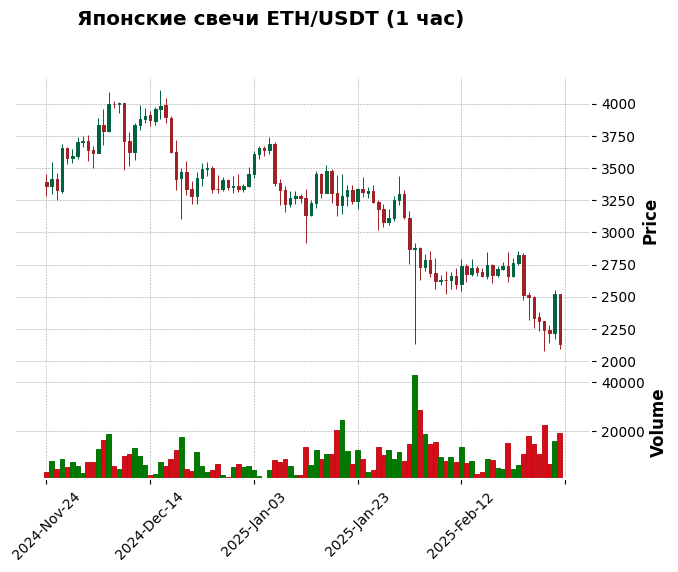

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 3)**

Empty DataFrame
Columns: [open, close, Z-Score]
Index: []


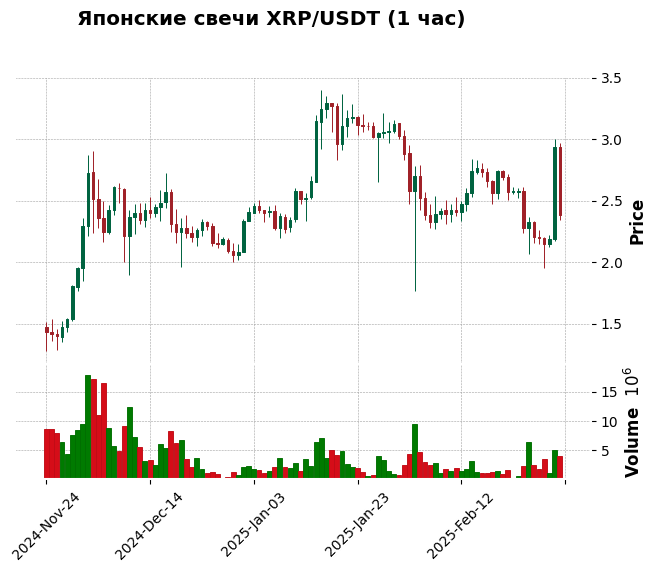

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 3)**

Empty DataFrame
Columns: [open, close, Z-Score]
Index: []


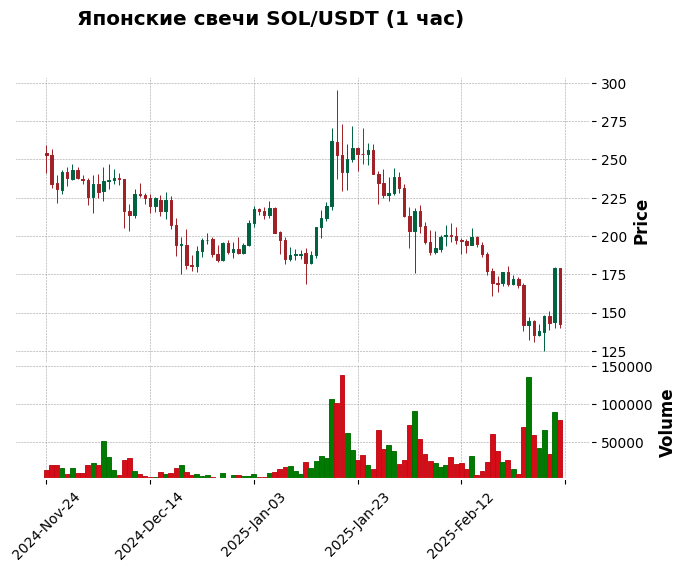

**Ищем пропуски**

open      0
high      0
low       0
close     0
volume    0
dtype: int64


**Ищем выбросы на цене закрытия (sigma = 3)**

Empty DataFrame
Columns: [open, close, Z-Score]
Index: []


In [31]:
tickers = ['BTC/USDT', 'ETH/USDT', 'XRP/USDT', 'SOL/USDT']

for t in tickers:
  ticker_df = load_ticker(ticker=t, days=100)
  # Так как крипта более волатильна, то для
  # нее используются три сигмы, вместо двух
  display_tickers(ticker_df=ticker_df, sigma=3)
